<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Beat Tracking by Dynamic Programming</h1> 
</div>

<br/>

<p>
Following Section 6.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a beat tracking procedure based on dynamic programming. This algorithm was originally described by Dan Ellis.

<ul>
<li><span style="color:black">
Daniel P.W. Ellis: <strong>Beat Tracking by Dynamic Programming.</strong> Journal of New Music Research, Vol. 36, No. 1, 51&ndash;60, 2007.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_Ellis07_BeatACF_JNMR.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 

## Problem Modelling 

There are many types of music with a strong and steady [beat](../C6/C6S2_TempoBeat.html), where the tempo is more or less constant throughout the entire recording. We now describe a beat tracking procedure which is based on the assumptions that beat positions go along with the strongest [note onsets](../C6/C6S1_OnsetDetection.html) and that the tempo is roughly constant. The main idea is to construct a score function that measures how well an arbitrary beat sequence reflects these two assumptions. The score-maximizing beat sequence constitutes the final beat tracking result. Such an optimal beat sequence can be computed efficiently using dynamic programming.

The input of the beat tracking procedure consists of a novelty function $\Delta:[1:N]\to\mathbb{R}$ as well as a rough estimate $\hat{\tau}\in\mathbb{R}_{>0}$ of the global tempo. As usual, we assume that the interval $[1:N]$ represents the sampled time axis used for the novelty feature computation. The tempo estimate $\hat{\tau}$ may be specified manually or obtained by an automated procedure. From $\hat{\tau}$ and the feature rate, one can derive an estimate for the beat period. For simplicity, we assume that the beat period is specified in terms of samples or feature indices (rather than in seconds). Let $\hat{\delta}\in\mathbb{N}$ be this number. Assuming a roughly constant tempo, the difference $\delta$ of two consecutive beats should be close to $\hat{\delta}$. To account for the deviation of $\delta$ from the ideal beat period $\hat{\delta}$, we introduce a **penalty function** $P_{\hat{\delta}}:\mathbb{N}\to\mathbb{R}$ by setting

\begin{equation}
\label{eq:BeatTempo:Beat:DP:NF}
P_{\hat{\delta}}(\delta) := - \big( \log_2 (\delta/\hat{\delta}) \big)^2
\end{equation}

for $\delta\in\mathbb{N}$. This function has a maximal value of zero at $\delta=\hat{\delta}$ and exhibits increasingly negative values for larger deviations. Furthermore, since tempo deviations are relative in nature (doubling the tempo should be penalized to the same degree as halving the tempo), the penalty function is defined to be symmetric on a logarithmic axis.

<!--<img src="../data/C6/FMP_C6_F21.png" width="300px" align="middle" alt="FMP_C6_F21">-->

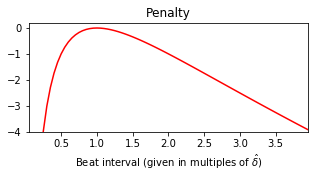

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

def compute_penalty(N, beat_ref):
    """| Compute penalty funtion used for beat tracking [FMP, Section 6.3.2]
    | Note: Concatenation of '0' because of Python indexing conventions

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        N (int): Length of vector representing penalty function
        beat_ref (int): Reference beat period (given in samples)

    Returns:
        penalty (np.ndarray): Penalty function
    """
    t = np.arange(1, N) / beat_ref
    penalty = -np.square(np.log2(t))
    t = np.concatenate((np.array([0]), t))
    penalty = np.concatenate((np.array([0]), penalty))
    return penalty

beat_ref = 20
N = 4 * beat_ref
penalty = compute_penalty(N, beat_ref)

plt.figure(figsize=(5, 2))
t = np.arange(0, N) / beat_ref
plt.plot(t, penalty, 'r')
plt.ylim([-4, 0.2])
plt.xlim([t[1], t[-1]])
plt.xlabel('Beat interval (given in multiples of $\hat{\delta}$)')
plt.title('Penalty')
plt.show()

For a given $N\in\mathbb{N}$, let 

$$B = (b_1,b_2,\ldots,b_L)$$ 

be a sequence of length $L\in\mathbb{N}_0$ consisting of strictly monotonically increasing beat positions $b_\ell\in[1:N]$ for $\ell\in[1:L]$. In the following, we refer to such a sequence as a **beat sequence**. By definition, the beat sequence of length $L=0$ is the empty sequence. Furthermore, let $\mathcal{B}^N$ denote the set consisting of all possible beat sequences for a given parameter $N\in\mathbb{N}$. To measure the quality of a beat sequence $B\in\mathcal{B}^N$, we introduce a score value $\mathbf{S}(B)$ that includes positive values of the novelty function $\Delta$ and negative values of the penalty function $P_{\hat{\delta}}$. To this end, we set

\begin{equation}
   \mathbf{S}(B) := \sum_{\ell=1}^L \Delta(b_\ell) 
          + \lambda \sum_{\ell=2}^L P_{\hat{\delta}}(b_\ell-b_{\ell-1}). 
\end{equation}

In particular, we obtain $\mathbf{S}(B)=0$ for the empty beat sequence with $L=0$. Furthermore, in the case $L=1$, we obtain $\mathbf{S}(B)=\Delta(b_1)$. In order to achieve a large score, the novelty values $\Delta(b_\ell)$ should be large, while the nonpositive penalty values $P_{\hat{\delta}}(b_\ell-b_{\ell-1})$ should be close to zero. The weight parameter $\lambda\in\mathbb{R}_{>0}$ is introduced to balance out these two conflicting conditions. The beat sequence

\begin{equation}
\label{eq:BeatTempo:Beat:DP:max}
   B^\ast := \mathrm{argmax}\big\{\mathbf{S}(B) \,\big|\, B\in\mathcal{B}^N\big\}
\end{equation}

that has the maximal score among all possible beat sequences yields the solution of the beat tracking problem. The following figure illustrates the definitions.

<img src="../data/C6/FMP_C6_F22.png" width="500px" align="middle" alt="FMP_C6_F22">

## Dynamic Programming Algorithm

The number of possible beat sequences is exponential in $N$. However, one can compute an optimal beat sequence efficiently using **dynamic programming**. We have already encountered this algorithmic paradigm when computing a [cost-minimizing warping path (DTW algorithm)](../C3/C3S2_DTWbasic.html) or a [probability-maximizing state sequence (Viterbi algorithm)](../C5/C5S3_Viterbi.html). The main idea is to break down the optimization problem into simpler subproblems by considering prefixes. In the beat tracking context, we consider prefixes of the underlying novelty function. More precisely, let $\mathcal{B}^N_n\subset\mathcal{B}^N $ denote the set of all beat sequences that end in $n\in[0:N]$. In other words, for a beat sequence $B = (b_1,b_2,\ldots,b_L)\in\mathcal{B}^N_n$, we have $b_L=n$. Note that, in the case $n=0$, the only possible beat sequence is the empty one. Let

\begin{equation}
   \mathbf{D}(n):= \max\left\{\mathbf{S}(B) \,\mid\, B\in\mathcal{B}^N_n \right\}     
\end{equation}

denote the maximal score over all beat sequences ending with $n\in[0:N]$. The value $\mathbf{D}(n)$ is also referred to as the **accumulated score**. Then it is not hard to see that 

\begin{equation}
     \mathbf{S}(B^\ast) = \max_{n\in[0:N]} \mathbf{D}(n).
\end{equation}

The values $\mathbf{D}(n)$ can be computed in an iterative fashion for $n=0,1,\ldots,N$. The following figure describes the procedure. Thanks to dynamic programming, the exponential number of operations needed to compute the score of all possible beat sequences is reduced to a number of operations that is quadratic in $N$. For further details, we refer to Section 6.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

<img src="../data/C6/FMP_C6_T01.png" width="600px" align="middle" alt="FMP_C6_T02">

## Implementation

We now implement the algorithm as described above. As an illustrative example, we consider the toy examples from Exercise 6.12 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, where a novelty as well as a penalty function are specified. 

**Important note:** In Python, indexing of lists, arrays, matrices, and so on starts with the **index 0**. To avoid an index shift within the function `compute_beat_sequence`, the novelty function is padded by a single value zero at the beginning. As a result, the implementation follows the algorithmic description above. Before returning the optimal beat sequence `B`, the index is adjusted by subtracting `-1` to again follow the Python convention. 

In [2]:
def compute_beat_sequence(novelty, beat_ref, penalty=None, factor=1.0, return_all=False):
    """| Compute beat sequence using dynamic programming [FMP, Section 6.3.2]
    | Note: Concatenation of '0' because of Python indexing conventions

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        novelty (np.ndarray): Novelty function
        beat_ref (int): Reference beat period
        penalty (np.ndarray): Penalty function (Default value = None)
        factor (float): Weight parameter for adjusting the penalty (Default value = 1.0)
        return_all (bool): Return details (Default value = False)

    Returns:
        B (np.ndarray): Optimal beat sequence
        D (np.ndarray): Accumulated score
        P (np.ndarray): Maximization information
    """
    N = len(novelty)
    if penalty is None:
        penalty = compute_penalty(N, beat_ref)
    penalty = penalty * factor
    novelty = np.concatenate((np.array([0]), novelty))
    D = np.zeros(N+1)
    P = np.zeros(N+1, dtype=int)
    D[1] = novelty[1]
    P[1] = 0
    # forward calculation
    for n in range(2, N+1):
        m_indices = np.arange(1, n)
        scores = D[m_indices] + penalty[n-m_indices]
        maxium = np.max(scores)
        if maxium <= 0:
            D[n] = novelty[n]
            P[n] = 0
        else:
            D[n] = novelty[n] + maxium
            P[n] = np.argmax(scores) + 1
    # backtracking
    B = np.zeros(N, dtype=int)
    k = 0
    B[k] = np.argmax(D)
    while P[B[k]] != 0:
        k = k+1
        B[k] = P[B[k-1]]
    B = B[0:k+1]
    B = B[::-1]
    B = B - 1
    if return_all:
        return B, D, P
    else:
        return B

# Example from Exercise 6.12 of [Müller, FMP, Springer 2015]
nov = np.array([0.1, 0.0, 1.0, 0.0, 1.0, 0.8, 0.0, 0.2, 0.4, 1.0, 0.0])
# Manually specified penality values (in practice, we use the function "compute_penalty")
penalty = np.array([0, -2, -0.2, 1.0, 0.5, -0.1, -1, -1.5, -3, -5, -8])
factor  = 1
beat = 3 

B,D,P = compute_beat_sequence(nov, beat, penalty=penalty, factor=1, return_all=True)    
df = pd.DataFrame([np.arange(1,len(nov)+1), nov, D[1:], P[1:]])
df.rename(index={0:'$n$', 1:'$\Delta(n)$',
                 2:'$\mathbf{D}(n)$', 3:'$\mathbf{P}(n)$'}, inplace=True)
df.rename_axis('$n$', axis='rows')

class Formatter(): 
    """Cass for converting column to row format 
    Notebook: C6/C6S3_BeatTracking.ipynb"""
    def __init__(self):
        self.i = 0
    def formatter(self, s):
        if self.i == 0 or self.i == 3:
            return_s = str(int(s))
        else:
            return_s = str(s)
        self.i += 1
        return return_s

ipd.display(ipd.HTML(df.to_html(formatters={i: Formatter().formatter for i in df.columns}, 
                                escape=False, header=False)))

print('Optimal beat sequency B:', B+1)

$n$,1,2,3,4,5,6,7,8,9,10,11
$\Delta(n)$,0.1,0.0,1.0,0.0,1.0,0.8,0.0,0.2,0.4,1.0,0.0
$\mathbf{D}(n)$,0.1,0.0,1.0,1.1,2.0,2.8,2.1,3.2,4.2,4.3,4.2
$\mathbf{P}(n)$,0,0,0,1,2,3,4,5,6,6,8


Optimal beat sequency B: [ 3  6 10]


## Example: Shostakovich 

We now consider a real music signal continuing with our [Shostakovich example](../C6/C6S1_NoveltyComparison.html). As input to our beat tracking procedure, we use a [spectral-based novelty function](../C6/C6S1_NoveltySpectral.html) computed at a sampling rate $F_\mathrm{s}^\Delta = 100~\mathrm{Hz}$. Expecting a dominant tempo between $200$ and $300~\mathrm{BPM}$, we set $\hat{\delta}=25$ (given in samples), which corresponds to $\hat{\tau}=240~\mathrm{BPM}$. The result below indicates that all beats (on the quarter note level) are detected correctly. In a second, experiment, we want to find an optimal beat sequence on the measure level assuming a tempo of $\hat{\tau}=80~\mathrm{BPM}$. Setting $\hat{\delta}=75$, the result is not as expected. The reason is that, within the 3/4 meter, the downbeats (as measured by the novelty function) are much weaker then the other beats. 
 
<img src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png" width="500px" align="left" alt="FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png">

<br clear="all" />

<audio style="width: 700px;" src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.mp3" type="audio/mpeg" controls="controls"></audio>

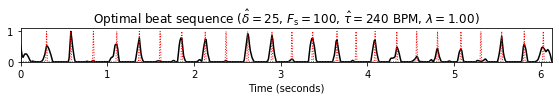

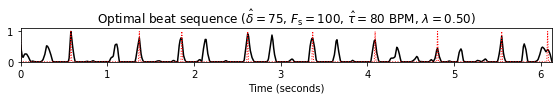

In [3]:
def beat_period_to_tempo(beat, Fs):
    """Convert beat period (samples) to tempo (BPM) [FMP, Section 6.3.2]

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        beat (int): Beat period (samples)
        Fs (scalar): Sample rate

    Returns:
        tempo (float): Tempo (BPM)
    """
    tempo = 60 / (beat / Fs)
    return tempo
    
def compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref, factor, title=None, figsize=(6, 2)):
    """Compute, plot, and sonfy beat sequence from novelty function [FMP, Section 6.3.2]

    Notebook: C6/C6S3_BeatTracking.ipynb

    Args:
        x: Novelty function
        Fs: Sample rate
        nov: Novelty function
        Fs_nov: Rate of novelty function
        beat_ref: Reference beat period
        factor: Weight parameter for adjusting the penalty
        title: Title of figure (Default value = None)
        figsize: Size of figure (Default value = (6, 2))
    """
    B = compute_beat_sequence(nov, beat_ref=beat_ref, factor=factor)

    beats = np.zeros(len(nov))
    beats[np.array(B, dtype=np.int32)] = 1
    if title is None:
        tempo = beat_period_to_tempo(beat_ref, Fs_nov)
        title = (r'Optimal beat sequence ($\hat{\delta}=%d$, $F_\mathrm{s}=%d$, '
                 r'$\hat{\tau}=%0.0f$ BPM, $\lambda=%0.2f$)' % (beat_ref, Fs_nov, tempo, factor))

    fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', title=title, figsize=figsize)
    T_coef = np.arange(nov.shape[0]) / Fs_nov
    ax.plot(T_coef, beats, ':r', linewidth=1)
    plt.show()

    beats_sec = T_coef[B]
    x_peaks = librosa.clicks(beats_sec, sr=Fs, click_freq=1000, length=len(x))
    ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=25, factor=1, figsize=(8,1.5))
compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=75, factor=0.5, figsize=(8,1.5))

## Limitations

The main limitation of the beat tracking procedure is its dependency on a single, predefined tempo $\hat{\tau}$. Using a small weighting parameter $\lambda$, the procedure may yield good beat tracking results even in the presence of local deviations from the ideal beat period $\hat{\delta}$. However, the presented procedure is not designed for handling music with slowly varying tempo (such as ritardando or accelerando) or abrupt changes in tempo. Despite these limitations, the simplicity and efficiency of the dynamic programming approach to beat tracking makes it an attractive choice for many types of music.

To illustrate the behavior of the beat tracker, we use a particularly mean example by considering a small expert (section from  $t_1=35~\mathrm{sec}$ to $t_2=53~\mathrm{sec}$) of an orchestra recording of the Hungarian Dance No. 5 by Johannes Brahms. The excerpt is challenging because of several sudden tempo changes. Furthermore, the input novelty function is very noise due to many soft and fuzzy onsets. 

<img src="../data/C6/FMP_C6_F19a.png" width="700px" align="center" alt="FMP_C6_F19a.png">

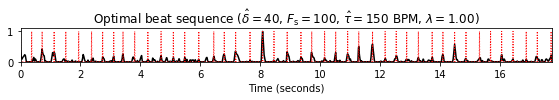

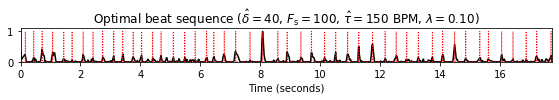

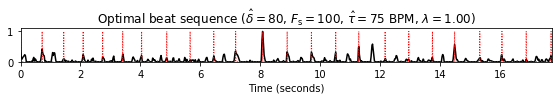

In [4]:
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F19_Brahms_Ormandy_sec35-53.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

beat_ref, factor = 40, 1
tempo = beat_period_to_tempo(beat_ref, Fs_nov)
compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=beat_ref, factor=factor, figsize=(8, 1.5))

beat_ref, factor = 40, 0.1
tempo = beat_period_to_tempo(beat_ref, Fs_nov)
compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=beat_ref, factor=factor, figsize=(8, 1.5))
   
beat_ref, factor = 80, 1
tempo = beat_period_to_tempo(beat_ref, Fs_nov)
compute_plot_sonify_beat(x, Fs, nov, Fs_nov, beat_ref=beat_ref, factor=factor, figsize=(8, 1.5))

## Further Notes


For modern pop and rock music with a strong beat and relatively steady tempo, the above beat tracking procedure by Dan Ellis yields good results as long as the novelty curve reveals most of the relevant beat onsets. To compute an optimal beat sequence, we discussed an efficient and elegant algorithm based on dynamic programming (DP)&mdash;a paradigm we have already encountered in the context of [dynamic time warping](../C3/C3S2_DTWbasic.html). The detection of periodic beat patterns becomes challenging when the music recording reveals significant tempo changes. In the notebook on [predominant pulse tracking](../C6/C6S3_PredominantLocalPulse.html) (PLP), we studied an alternative approach that aims at detecting locally periodic patterns such that even sudden tempo changes may be captured (with a small delay specified by the length of the analysis window). In particular, a combined usage of novelty and PLP functions (e.g. by considering a linear combination of these two functions) may help to increase the overall robustness of a beat tracking procedure (e.g. using Ellis' DP-based beat tracker). For a more detailed discussion of related work, we refer to Section 6.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>